In [1]:
%pylab nbagg
import time
from collections import Counter
import numpy as np
import sys
sys.path.insert(0,'../comocma')
import cma
import como
%pwd

Populating the interactive namespace from numpy and matplotlib


'/Users/hansen/gitlab/randopt/code-mo/ipython-notebooks'

In [2]:
class COMOPlotCallback:
    """plot dynamically into the current figure

    Uses the `archive` attribute of `Sofomore`.

    A quick hack that depends on ``%pylab nbagg``.
    Plots f-space and attributes like sigma, condition
    number of kernels.

    Can be used as callback or within the ask-and-tell loop.
"""
    def __init__(self, another_self=None):
        self.nkernels = []  # evolution of number of kernels, usually range(1, len(moes)+1)
        self._archive_HVs = []
        self._final_HVs_kernel = []
        self._final_HVs_archive = []
        self.lazygap = 1
        self.counter = 0
        if another_self:  # keep generated lists mainly for developing purpose
            for name in dir(another_self):  # could also use __dict__
                if not name.startswith("__"):
                    setattr(self, name, getattr(another_self, name))
    def archive_HVs(self, moes):
        if not len(self.nkernels) or len(moes) > self.nkernels[-1]:
            self.nkernels += [len(moes)]
            try:
                self._archive_HVs += [moes.archive.hypervolume]
            except AttributeError:  # no archive
                # TODO: use kernel list
                pass  # no archive is collected
            # check domination in both sets
            if len(moes) > 1:
                f_pair = moes[-2].objective_values
                try:
                    self._final_HVs_kernel += [moes._UHVI_indicator(moes[-2])(f_pair)]
                    self._final_HVs_archive += [moes.archive.contributing_hypervolume(f_pair)]
                except (AttributeError, TypeError):  # may be the wrong types
                    if self.counter < 2:
                        warnings.warn("this only works with future versions of como/moarchiving")
        else:
            self._archive_HVs[-1] = moes.archive.hypervolume
        return self._archive_HVs
    def __call__(self, moes):
        """callback function, change the lazygap when called with an int"""
        try:
            if int(moes) == moes:    # interpret the single parameter
                self.lazygap = moes  # as lazygap, more convenient than
                return               # an optional parameter
        except: pass
        
        def _subplot(*args):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                return subplot(*args)
        def make_xy(y):
            """xy[0] is the running number, xy[1] is the data"""
            return np.asarray(list(enumerate(y))).T

        def make_xy1(y):
            """xy[0] is x axis, xy[1] is y axis of ecdf"""
            return cma.optimization_tools.step_data(y, smooth_corners=0)
        
        def hypervolume_contribution_of_kernel_in_archive(moes, kernel):
            """for last kernel"""
            if kernel.objective_values is None:
                return float('-inf')
            try:
                i = moes.archive.index(kernel.objective_values)
            except ValueError:  # k not in archive
                return float(moes.archive.hypervolume_improvement(kernel.objective_values))
            else:
                return float(moes.archive.contributing_hypervolume(i))

        def hypervolume_contributions_of_kernels(moes, archive):
            res = []
            for k in moes:
                if k.objective_values is None:
                    continue
                try:
                    i = archive.index(k.objective_values)
                except ValueError:  # k not in archive
                    res += [float(archive.hypervolume_improvement(k.objective_values))]
                else:
                    res += [float(archive.contributing_hypervolume(i))]                    
            return res
        
        all_subplots = 220

        hvs = self.archive_HVs(moes)  # update information in the process
        if self.counter % self.lazygap > 0.99:
            self.counter += 1
            return self  # return self on first call
        self.counter += 1
        
        # gcf().set_size_inches(9, 4)  # may not work
        # axes().set_aspect('equal')  # isn't effective

        s = _subplot(all_subplots + 3)
        s.cla()  # clear subplot
        title('%d Kernels, %d doms, HV=%.9e' % (
            len(moes), len(moes) - len(moes.pareto_front),
            moes.pareto_front.hypervolume), fontsize=9)
        xy = np.asarray([k.objective_values for k in moes
                         if k.objective_values])
        plt.plot(xy[:,0], xy[:,1], 'C1o', label="_nolegend_")  # all kernels
        xy = np.asarray([moes[i].objective_values
                         for i in moes._active_indices
                         if moes[i].objective_values])
        if len(xy):  # plot active kernels
            plt.plot(xy[:,0], xy[:,1], 'ro', label="_nolegend_")
        xy = np.asarray([k.objective_values for k in moes
                         if k.objective_values and
                           moes.archive.count(k.objective_values) == 0])        
        if len(xy):
            plt.plot(xy[:,0], xy[:,1], 'kx', label='not in archive')
            legend()

        s = _subplot(all_subplots + 1)
        s.cla()
        non_dominated_kernels = [k.objective_values for k in moes
                                 if k.objective_values in moes.archive]
        title('Archive: %d/%d kernels, HV=%.9e' % (
                len(non_dominated_kernels), len(moes.archive), moes.archive.hypervolume),
              fontsize=7)
        xy = np.asarray(moes.archive)
        len(xy) and plt.plot(xy[:,0], xy[:,1], '.')
        xy = np.asarray(non_dominated_kernels)
        len(xy) and plt.plot(xy[:,0], xy[:,1], '.')
        # moes.logger.plot_front()  # TODO: plot kernels below and in right color
        
        # s = _subplot(1, 3, 2)

        #-----------
        s = _subplot(all_subplots + 4)  # ECDFs
        s.cla()
        title('cHV ECDFs, last kernel=%e (todo: what else?)' % (
            hypervolume_contribution_of_kernel_in_archive(moes, moes[-2])
            if len(moes) > 1 else -1), fontsize=9)
        xy = make_xy1([float(v) for v in moes.archive.contributing_hypervolumes])
        plot(xy[0], xy[1], label='archive/archive')
        legend(fontsize=9)
        linthreshx = np.min(np.abs(xy[0][xy[0] != 0])) if len(xy[0] != 0) else 1

        if len(moes) > 1:
            xy = make_xy1(hypervolume_contributions_of_kernels(moes, moes.pareto_front))
            # semilogx(xy[:,1], xy[:,0] / len(xy[:,0]))
            plot(xy[0], xy[1], label='kernels/kernels')
            y = hypervolume_contributions_of_kernels(moes, moes.archive)
            xy = make_xy1(y)
            len(xy) and plot(xy[0], xy[1], label='kernels/archive')
            xy = make_xy1(self._final_HVs_kernel)
            len(xy) and plot(xy[0], xy[1], label='kernel[t(end)]/kernels[t]')
            xy = make_xy1(self._final_HVs_archive)
            len(xy) and plot(xy[0], xy[1], label='kernel[t(end)]/archive[t]')
            xscale('symlog', linthreshx=linthreshx)
            # TODO: need to make x-annotation smaller
            gca().tick_params(axis='x', labelsize=5)
            legend(fontsize=7)

            s = _subplot(all_subplots + 2)  # various plotted vs iterations
            s.cla()
            semilogy(*make_xy([k.countiter for k in moes]), 'b.')
            semilogy(*make_xy([k.sigma for k in moes]), 'g.')
            semilogy(*make_xy([k.sigma0 for k in moes]), 'g.', label="_nolegend_")
            semilogy(*make_xy([k.sm.condition_number for k in moes]), 'r.')
            if hvs:
                maxhv = max(hvs)
                semilogy(*make_xy(diff([0] + hvs)), 'k-')
                semilogy(*make_xy([-hv + maxhv for hv in hvs]), 'c-')
                title(# xlim()[0], ylim()[1], 
                     '%d, %d, %.13e' % (
                         sum([k.countiter for k in moes]),
                         sum([k.countevals for k in moes]),
                         maxhv
                         # float(moes.archive.hypervolume),
                     ), 
                    fontsize=8)
            legend(['iterations', 'sigma',
                    'condition number',
                    'HV improvement (archive)',
                   '-HV + max(HV) of archive'],
                   fontsize=7)
            grid(which='both')
            xlabel('Sofomore iterations')
        plt.tight_layout()
        show()
        gcf().canvas.draw()
try: plot_callback = COMOPlotCallback(plot_callback)
except: plot_callback = COMOPlotCallback()

In [3]:
dimension = 5
num_kernels = 1 # number of single-objective solvers (population size)
refpoint = [131, 131]
sigma0 = 5.2
fun1 = cma.ff.sphere  # cma.ff.sphere
fun2 = lambda x: cma.ff.sphere(x-4)
fitness = como.FitFun(fun1, fun2)
selected_restarts = como.best_chv_restart_kernel

list_of_solvers = como.get_cmas(2 * (np.random.rand(num_kernels, dimension) - 1/2),
                                sigma0, {'tolfunrel': 1e-9,
                                        'verb_log': 0, 'verbose': -9,
                                        }) # produce `num_kernels cma instances`
moes = como.Sofomore(list_of_solvers, 
                     opts = {# 'archive': False, 
                             'restart': como.best_chv_restart_kernel,
                             # 'indicator_front': 'archive',
                            }, 
                     reference_point = refpoint) # create a como-cma-es instance
#moes = como.Sofomore(list_of_solvers, opts = {'archive': True}, reference_point = refpoint) # create a como-cma-es instance
plot_callback = COMOPlotCallback()
# moes.optimize(fitness, iterations=3)

<IPython.core.display.Javascript object>


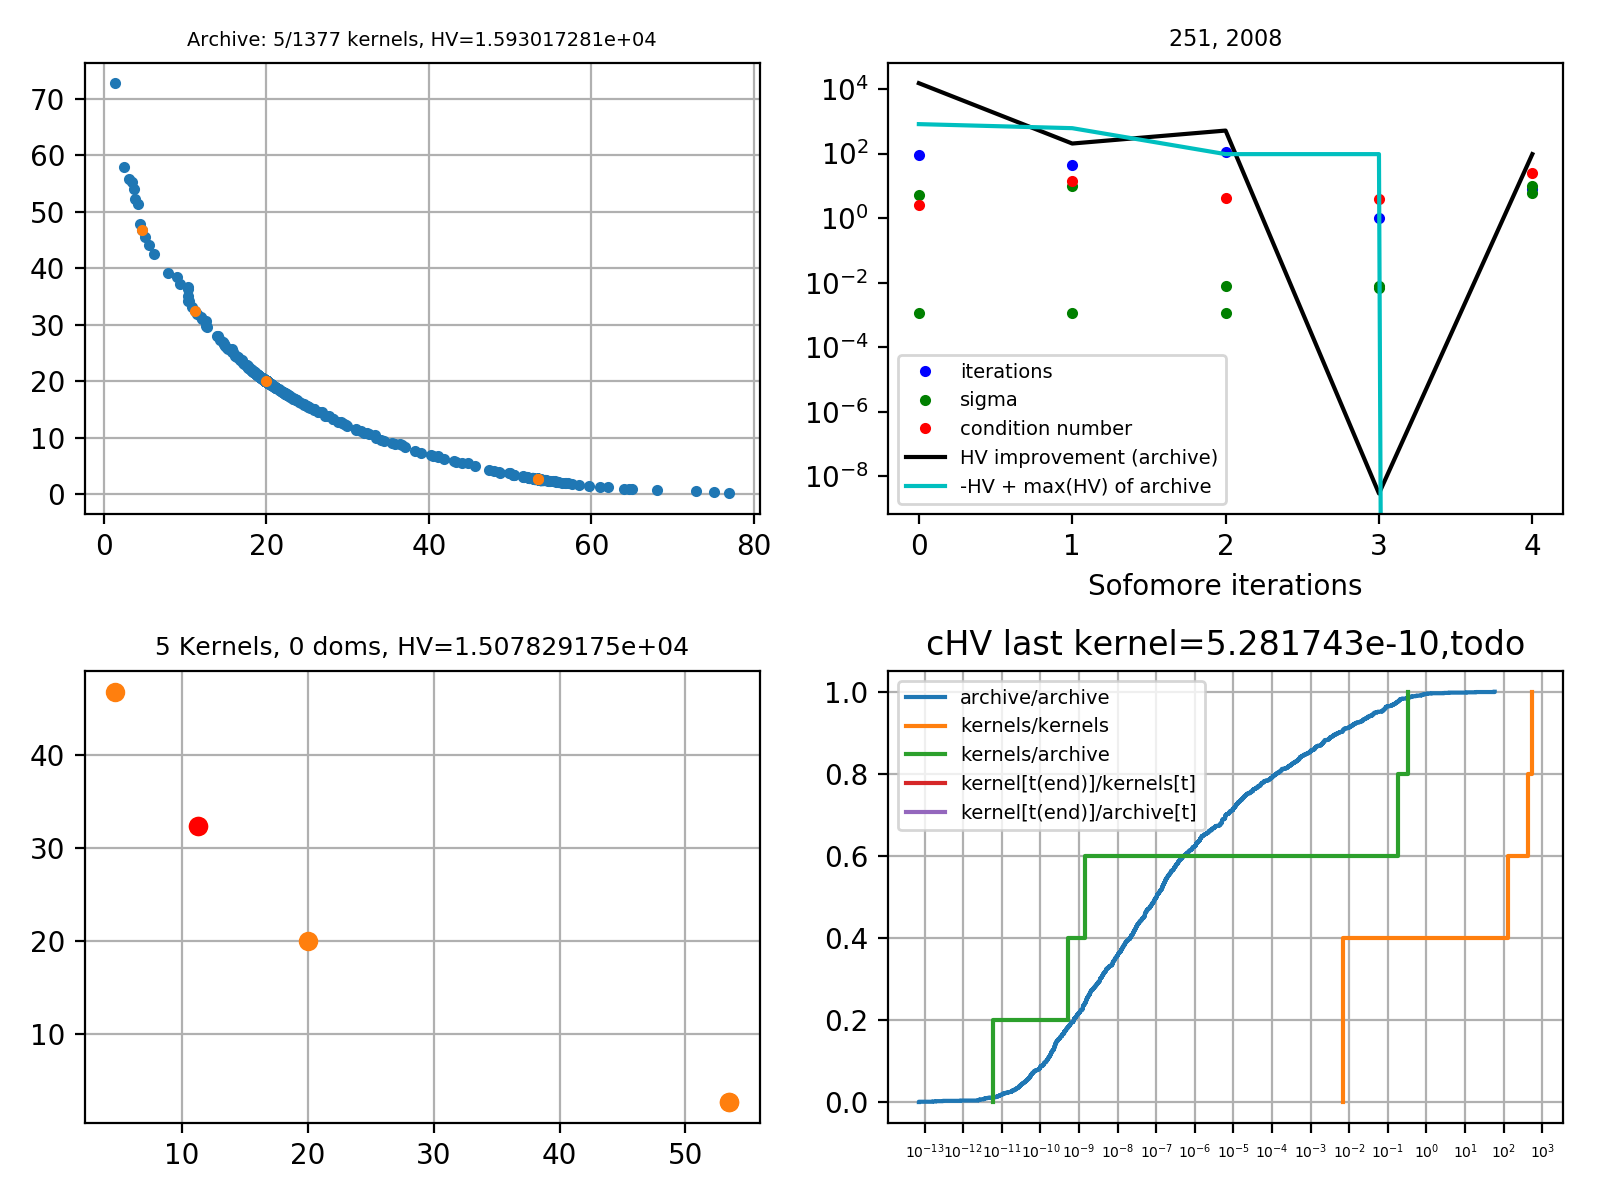

In [4]:
figure(figsize=(8, 6));

In [5]:
# to be executed repeatedly
niter = 260
plot_callback(50)  # plot every 50 iterations (plotting is time consuming)
t0 = time.time()
moes.optimize(fitness, iterations=niter, callback=[plot_callback])
[k.countiter for k in moes]
print(int(1e3 * (time.time() - t0) / niter), 'ms per iteration')
Counter([tuple(k.stop()) for k in moes]), # moes.restart.counts

Iterat #Fevals   Hypervolume   axis ratios   sigmas   min&max stds
                                  (median)  (median)    (median)
    1      9 5.635939075642142e+03 1.0e+00 4.73e+00  4e+00  5e+00
    2     18 0.000000000000000e+00 1.2e+00 4.18e+00  4e+00  4e+00
    3     27 1.059897790918475e+04 1.3e+00 3.95e+00  3e+00  4e+00
  100    901 1.232641627201388e+04 2.3e+00 1.01e-02  6e-04  1e-03
  200   1802 1.495187806259437e+04 1.9e+00 5.63e-01  2e-02  2e-02
time per iteration: 0.01614910730948815


Counter({('tolfunrel',): 1, ('tolfacupx',): 1, ('tolx',): 2, (): 1})